# TP3 
par Skander Meziou

Raw extraction output:  Harry Potter and the Prisoner of Azkaban  2004  publication date  fantasy film  genre  Alfonso Cuarón  director  Steve Kloves  screenwriter  Harry Potter film series  part of the series  Harry Potter and the Chamber of Secrets  fantasy film  genre  Alfonso Cuarón  director  Harry Potter film series  part of the series  Harry Potter film series  Harry Potter and the Prisoner of Azkaban  has part  Harry Potter and the Chamber of Secrets 
Raw extraction output:  Sirius Black  Azkaban  residence
Raw extraction output:  Professor Albus Dumbledore  Michael Gambon  performer
Raw extraction output:  Prisoner of Azkaban  31 May 2004  publication date
Raw extraction output:  Best Original Music Score  Academy Awards  instance of  Best Visual Effects  Academy Awards  instance of

Extracted Triples:
('Harry Potter and the Prisoner of Azkaban', 'publication date', '2004')
('Sirius Black', 'residence', 'Azkaban')
('Professor Albus Dumbledore', 'performer', 'Michael Gambon')
(

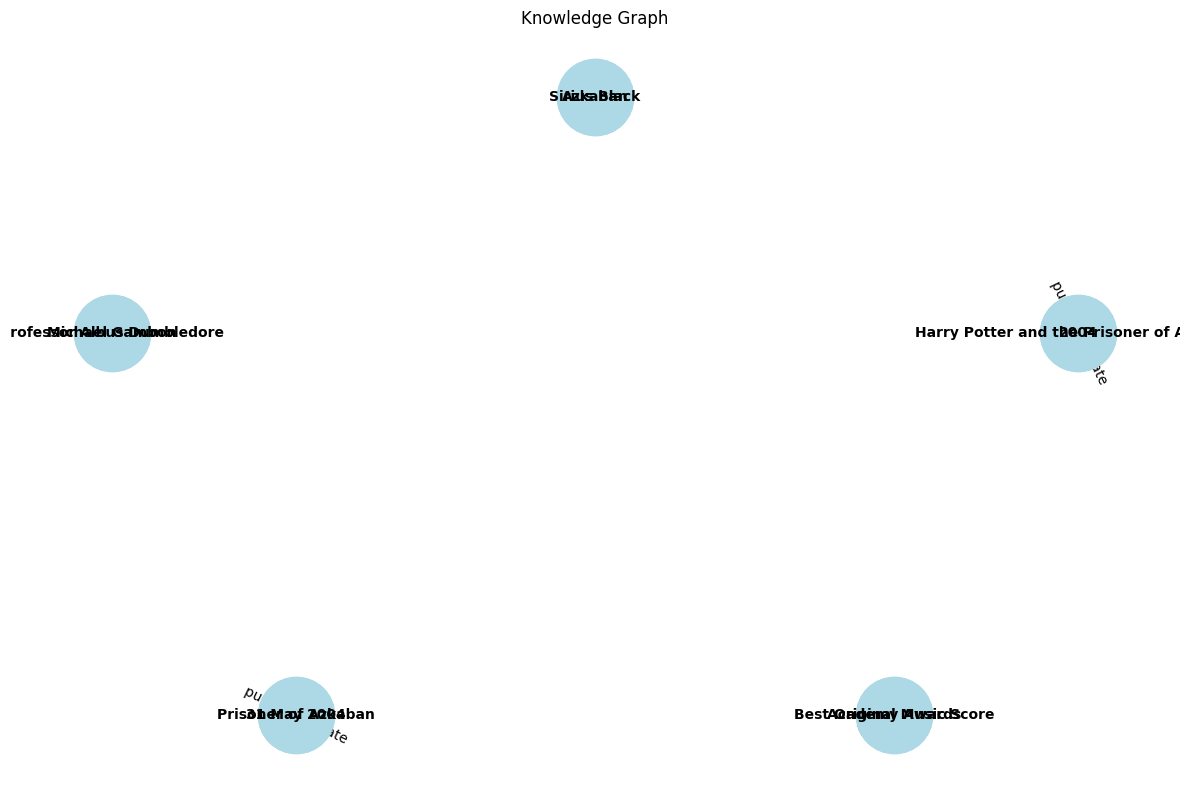

In [11]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import networkx as nx
import matplotlib.pyplot as plt

# Load the REBEL model
model_name = "Babelscape/rebel-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# The text to process
text = """
Harry Potter and the Prisoner of Azkaban is a 2004 fantasy film directed by Alfonso Cuarón from a screenplay by Steve Kloves. It is based on the 1999 novel Harry Potter and the Prisoner of Azkaban by J. K. Rowling. It is the sequel to Harry Potter and the Chamber of Secrets (2002) and the third instalment in the Harry Potter film series. The film stars Daniel Radcliffe as Harry Potter, alongside Rupert Grint and Emma Watson as Harry's best friends Ron Weasley and Hermione Granger respectively. It chronicles Harry's third year at Hogwarts and his quest to uncover the truth about his past, including the connection recently-escaped Azkaban prisoner Sirius Black has to Harry and his deceased parents.

With this film, the Harry Potter series switched to a longer eighteen-month production cycle. Cuarón was selected as director from a list that included Callie Khouri and Kenneth Branagh. The cast of previous instalments returned for the film, with the additions of Gary Oldman, David Thewlis, Timothy Spall, and Emma Thompson, among others. It was the first appearance of Michael Gambon as Professor Albus Dumbledore, due to Richard Harris's death in 2002. Principal photography began in February 2003 at Leavesden Film Studios. It was the first in the series to extensively use real-life locations, with sets built in Scotland and scenes shot in London. Filming wrapped in November 2003.

The film was released on 31 May 2004 in the United Kingdom, and on 4 June 2004 in North America. It was the first Harry Potter film to use IMAX Technology and released into IMAX theatres. Prisoner of Azkaban grossed a total of $808 million worldwide, making it the second-highest-grossing film of 2004, behind Shrek 2. Critics praised Cuarón's direction and the lead actors' performances. It is credited for marking a notable shift in the franchise's tone and directing style and is often regarded by critics and fans alike as the best Harry Potter film. It was nominated for two Academy Awards, Best Original Music Score and Best Visual Effects, at the 77th Academy Awards in 2004. It was followed by Harry Potter and the Goblet of Fire in 2005. 
"""
#pour etre sur de pas depasser le nombre de token
def split_text(text, max_length=512):
    """Split text into blocks of manageable length"""
    sentences = text.split(". ")
    blocks = []
    current_block = ""
    for sentence in sentences:
        if len(current_block) + len(sentence) <= max_length:
            current_block += sentence + ". "
        else:
            blocks.append(current_block.strip())
            current_block = sentence + ". "
    if current_block:
        blocks.append(current_block.strip())
    return blocks

def extract_entities_and_relations(block):
    """Extract entities and relations from a text block"""
    inputs = tokenizer(block, return_tensors="pt", truncation=True, max_length=512)
    outputs = model.generate(**inputs)
    decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    print(f"Raw extraction output: {decoded_output[0]}")
    return decoded_output[0]

def parse_rebel_output(output):
    """Parse the REBEL model output into triples"""
    triples = []
    statements = output.split('\n')
    for statement in statements:
        parts = statement.split('  ')
        if len(parts) >= 3:
            subject = parts[0].strip()
            obj = parts[1].strip()
            relation = parts[2].strip()
            if subject and obj and relation:
                triples.append((subject, relation, obj))
    return triples

def create_graph(triples):
    """Create a NetworkX graph from triples"""
    graph = nx.DiGraph()
    for triple in triples:
        print(f"Triple: {triple}")
        if len(triple) == 3 and all(triple):
            subject, relation, obj = triple
            graph.add_node(subject)
            graph.add_node(obj)
            graph.add_edge(subject, obj, label=relation)

    return graph

def plot_graph(graph):
    """Visualize the knowledge graph"""
    plt.figure(figsize=(12,8))
    if len(graph) == 0:
        print("Warning: Graph is empty!")
        return
    pos = nx.kamada_kawai_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_color="lightblue", node_size=3000)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_weight="bold")
    nx.draw_networkx_edges(graph, pos)
    edge_labels = nx.get_edge_attributes(graph, 'label')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

    plt.title("Knowledge Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

text_blocks = split_text(text)

triples = []
for block in text_blocks:
    result = extract_entities_and_relations(block)
    block_triples = parse_rebel_output(result)
    triples.extend(block_triples)

print("\nExtracted Triples:")
for triple in triples:
    print(triple)

knowledge_graph = create_graph(triples)
plot_graph(knowledge_graph)

In [ ]:
import requests
import re

def get_wikipedia_summary(title, year=-1, language="en"):
    """
    Récupère le résumé d'un article Wikipédia ou sélectionne une sous-page pertinente.
    :param title: Titre de la page Wikipédia.
    :param year: Année associée au film (par défaut -1 pour ignorer).
    :param language: Langue de l'article (par défaut "en").
    :return: Résumé textuel de l'article.
    """
    url = f"https://{language}.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
        "redirects": 1  # Suivre les redirections
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        page = next(iter(data["query"]["pages"].values()))

        # Cas où la page contient "may refer to"
        if "extract" in page and "may refer to" in page["extract"]:
            # Extraire les sous-pages mentionnées dans la section
            subpages = re.findall(r"(?<=\n)Frozen \((.*?)\)", page["extract"])
            if year != -1:
                # Filtrer les sous-pages contenant l'année
                matching_pages = [sp for sp in subpages if str(year) in sp]
                if matching_pages:
                    print(f"Correspondance trouvée : Frozen ({matching_pages[0]})")
                    return get_wikipedia_summary(f"Frozen ({matching_pages[0]})", language=language)
            # Si aucune correspondance avec l'année, choisir la première sous-page
            if subpages:
                print(f"Aucune année précise trouvée. Sélection de : Frozen ({subpages[0]})")
                return get_wikipedia_summary(f"Frozen ({subpages[0]})", language=language)
            else:
                print("Aucune sous-page identifiable.")
                return None

        # Retourner le résumé de la page normale
        if "extract" in page:
            return page["extract"]
        else:
            print(f"Aucun résumé trouvé pour le titre '{title}'.")
            return None
    else:
        print(f"Erreur lors de la requête : {response.status_code}")
        return None


# Exemple d'utilisation
summary = get_wikipedia_summary("Frozen", year=2013, language="en")
if summary:
    print(f"Résumé de la page sélectionnée :\n{summary[:500]}...")  # Affiche les 500 premiers caractères


KeyboardInterrupt: 

Raw extraction output:  Ralph Breaks the Internet  Rich Moore  director  Phil Johnston  director  Clark Spencer  producer  Pamela Ribon  screenwriter  Walt Disney Animation Studios  Walt Disney Pictures  owned by  Walt Disney Pictures  Walt Disney Animation Studios  owner of  Wreck-It Ralph  Rich Moore  director  Phil Johnston  screenwriter  Clark Spencer  screenwriter  Pamela Ribon  screenwriter
Raw extraction output:  first film  John C. Reilly  cast member  Sarah Silverman  cast member  Jack McBrayer  cast member  Jane Lynch  cast member  Ed O'Neill  cast member  Gal Gadot  cast member  Taraji P. Henson  cast member  Alfred Molina  cast member  Alan Tudyk  cast member
Raw extraction output:  Vanellope von Schweetz  Wreck-It Ralph  present in work  Wreck-It Ralph  Vanellope von Schweetz  characters
Raw extraction output:  Ralph Breaks the Internet  Walt Disney Animation Studios  production company  November 5, 2018  publication date  Ralph Breaks the Internet  Walt Disney Animation S

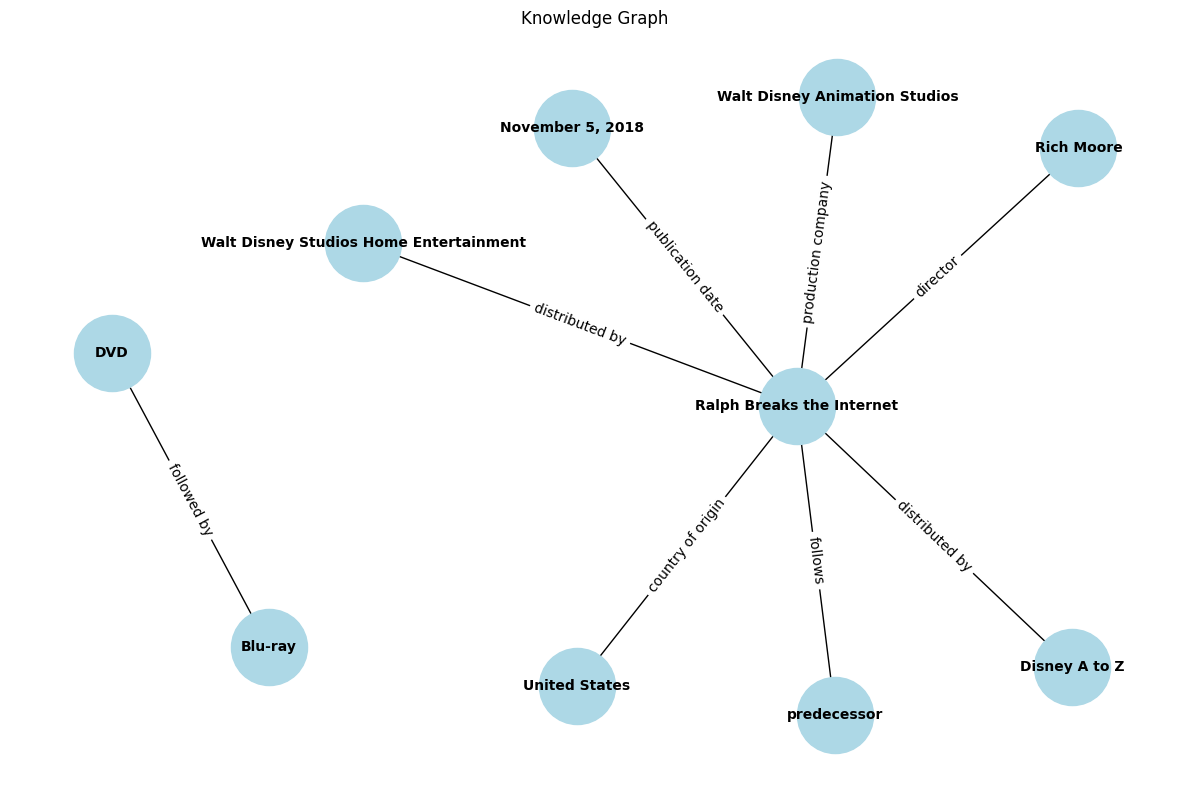

In [36]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import networkx as nx
import matplotlib.pyplot as plt
import requests

# Charger le modèle REBEL
model_name = "Babelscape/rebel-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


# Fonction pour découper le texte en blocs
def split_text(text, max_length=512):
    sentences = text.split(". ")
    blocks = []
    current_block = ""
    for sentence in sentences:
        if len(current_block) + len(sentence) <= max_length:
            current_block += sentence + ". "
        else:
            blocks.append(current_block.strip())
            current_block = sentence + ". "
    if current_block:
        blocks.append(current_block.strip())
    return blocks

# Extraction des entités et relations avec REBEL
def extract_entities_and_relations(block):
    inputs = tokenizer(block, return_tensors="pt", truncation=True, max_length=512)
    outputs = model.generate(**inputs)
    decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    print(f"Raw extraction output: {decoded_output[0]}")
    return decoded_output[0]

# Parser les triples extraits par REBEL
def parse_rebel_output(output):
    triples = []
    statements = output.split('\n')
    for statement in statements:
        parts = statement.split('  ')
        if len(parts) >= 3:
            subject = parts[0].strip()
            obj = parts[1].strip()
            relation = parts[2].strip()
            if subject and obj and relation:
                triples.append((subject, relation, obj))
    return triples

# Filtrer les triples pertinents
def filter_triples(triples, title, relevant_relations=None):
    if relevant_relations is None:
        relevant_relations = ["followed by", "follows"]
    filtered = []
    for triple in triples:
        subject, relation, obj = triple
        if title.lower() in subject.lower() or title.lower() in obj.lower() or relation.lower() in relevant_relations:
            filtered.append(triple)
    return filtered

# Créer un graphe NetworkX à partir des triples
def create_graph(triples):
    graph = nx.DiGraph()
    for triple in triples:
        print(f"Triple: {triple}")
        if len(triple) == 3 and all(triple):
            subject, relation, obj = triple
            graph.add_node(subject)
            graph.add_node(obj)
            graph.add_edge(subject, obj, label=relation)
    return graph

# Visualiser le graphe
def plot_graph(graph):
    plt.figure(figsize=(12, 8))
    if len(graph) == 0:
        print("Warning: Graph is empty!")
        return
    pos = nx.kamada_kawai_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_color="lightblue", node_size=3000)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_weight="bold")
    nx.draw_networkx_edges(graph, pos)
    edge_labels = nx.get_edge_attributes(graph, 'label')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.title("Knowledge Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Pipeline principal
title = "Ralph Breaks the Internet"
text = get_wikipedia_summary(title, language="en")

if text:
    text_blocks = split_text(text)
    triples = []

    for block in text_blocks:
        result = extract_entities_and_relations(block)
        block_triples = parse_rebel_output(result)
        triples.extend(block_triples)

    # Filtrer les triples pour garder uniquement ceux pertinents
    filtered_triples = filter_triples(triples, title, relevant_relations=["followed by", "follows"])

    print("\nFiltered Triples:")
    for triple in filtered_triples:
        print(triple)

    # Créer et afficher le graphe
    knowledge_graph = create_graph(filtered_triples)
    plot_graph(knowledge_graph)



Traitement du film : Ralph Breaks the Internet
Raw extraction output:  Ralph Breaks the Internet  Rich Moore  director  Phil Johnston  director  Clark Spencer  producer  Pamela Ribon  screenwriter  Walt Disney Animation Studios  Walt Disney Pictures  owned by  Walt Disney Pictures  Walt Disney Animation Studios  owner of  Wreck-It Ralph  Rich Moore  director  Phil Johnston  screenwriter  Clark Spencer  screenwriter  Pamela Ribon  screenwriter
Raw extraction output:  first film  John C. Reilly  cast member  Sarah Silverman  cast member  Jack McBrayer  cast member  Jane Lynch  cast member  Ed O'Neill  cast member  Gal Gadot  cast member  Taraji P. Henson  cast member  Alfred Molina  cast member  Alan Tudyk  cast member
Raw extraction output:  Vanellope von Schweetz  Wreck-It Ralph  present in work  Wreck-It Ralph  Vanellope von Schweetz  characters
Raw extraction output:  Ralph Breaks the Internet  Walt Disney Animation Studios  production company  November 5, 2018  publication date  Ra

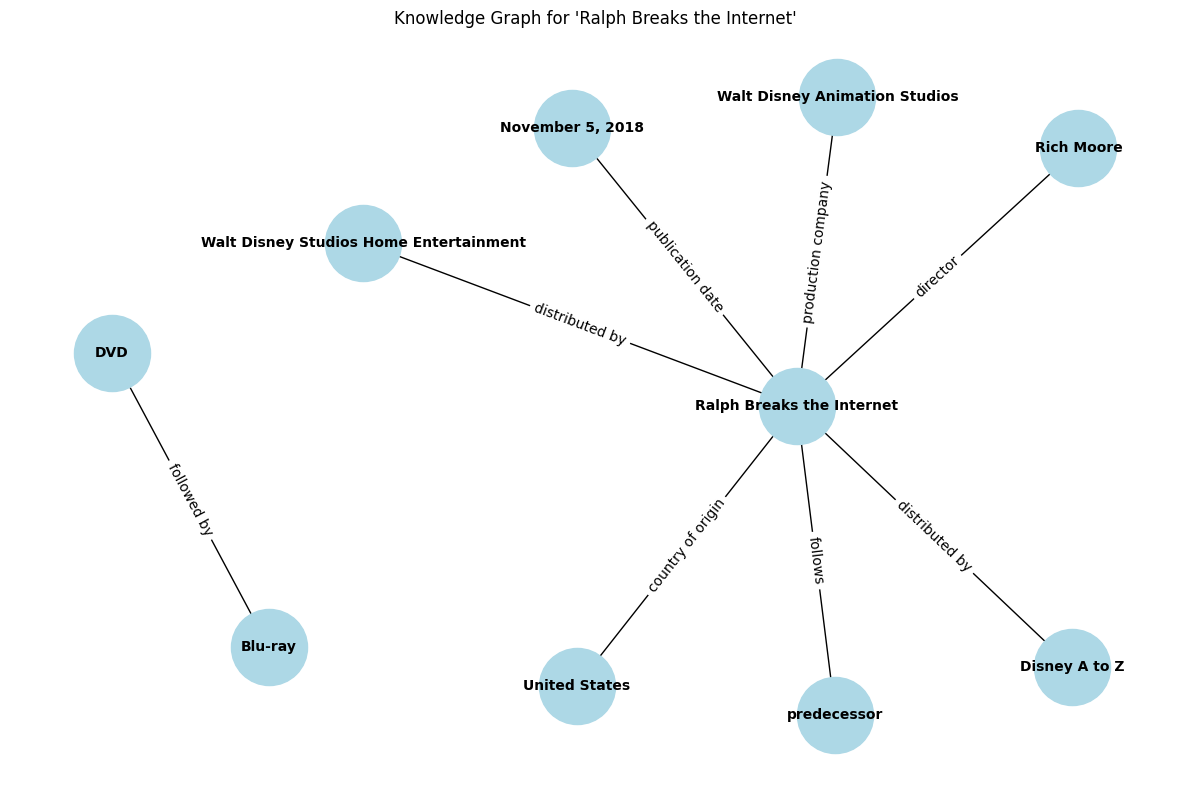


Traitement du film : Frozen
Raw extraction output:  World War I  World War II  followed by  World War II  World War I  follows
Raw extraction output:  Sentenced  1998  work period (start)  The Heart of Everything  2007  publication date  Hans Christian Andersen  The Snow Queen  notable work  The Snow Queen  Hans Christian Andersen  author

Filtered Triples for 'Frozen':
('World War I', 'followed by', 'World War II')
Triple: ('World War I', 'followed by', 'World War II')


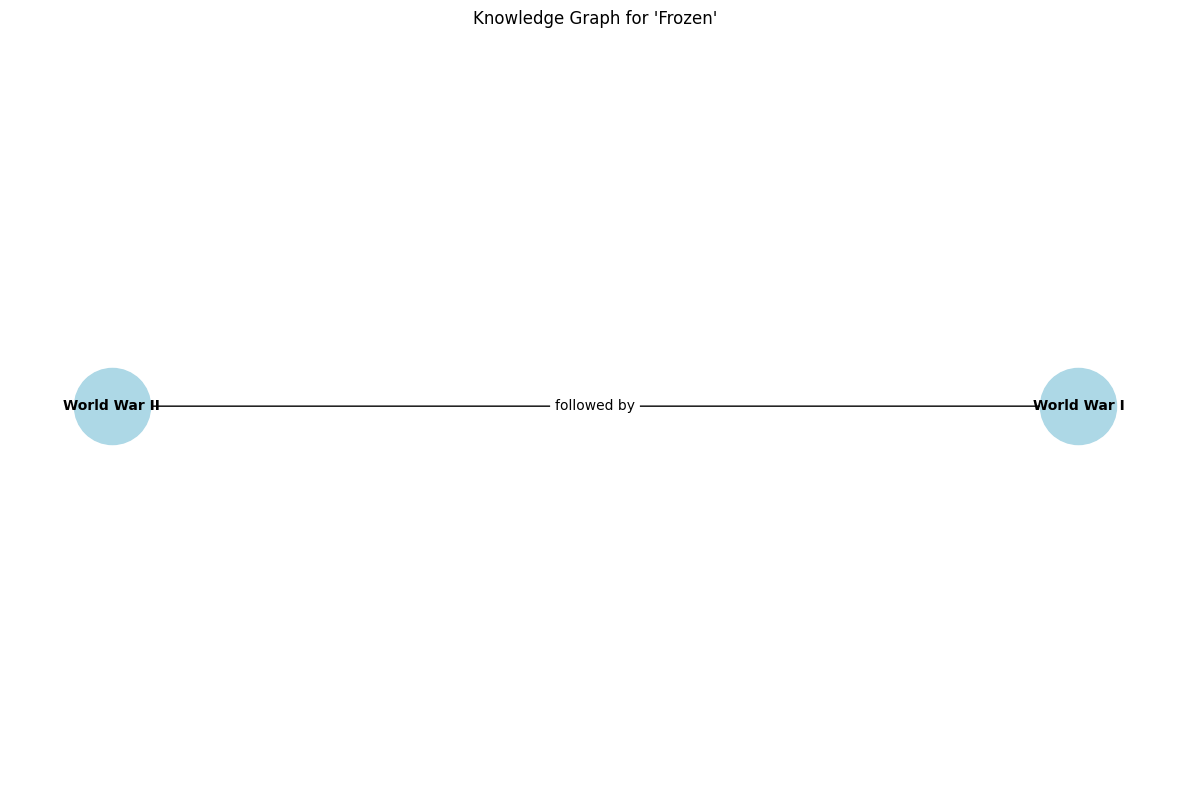


Traitement du film : Inception
Raw extraction output:  Inception  action  genre  heist  genre  Christopher Nolan  director  Leonardo DiCaprio  cast member  Emma Thomas  producer  Christopher Nolan  Emma Thomas  spouse  Emma Thomas  Christopher Nolan  spouse
Raw extraction output:  Insomnia  Ken Watanabe  cast member  Joseph Gordon-Levitt  cast member  Marion Cotillard  cast member  Elliot Page  cast member  Tom Hardy  cast member  Cillian Murphy  cast member  Tom Berenger  cast member  Dileep Rao  cast member  Michael Caine  cast member
Raw extraction output:  Batman Begins  Warner Bros.  distributed by  The Prestige  Warner Bros.  distributed by  The Dark Knight  Warner Bros.  distributed by
Raw extraction output:  Inception  July 8, 2010  publication date  July 16, 2010  publication date  Inception  July 8, 2010  publication date  July 16, 2010  publication date
Raw extraction output:  Inception  Best Cinematography  award received  Best Sound Editing  award received  Best Sound Mix

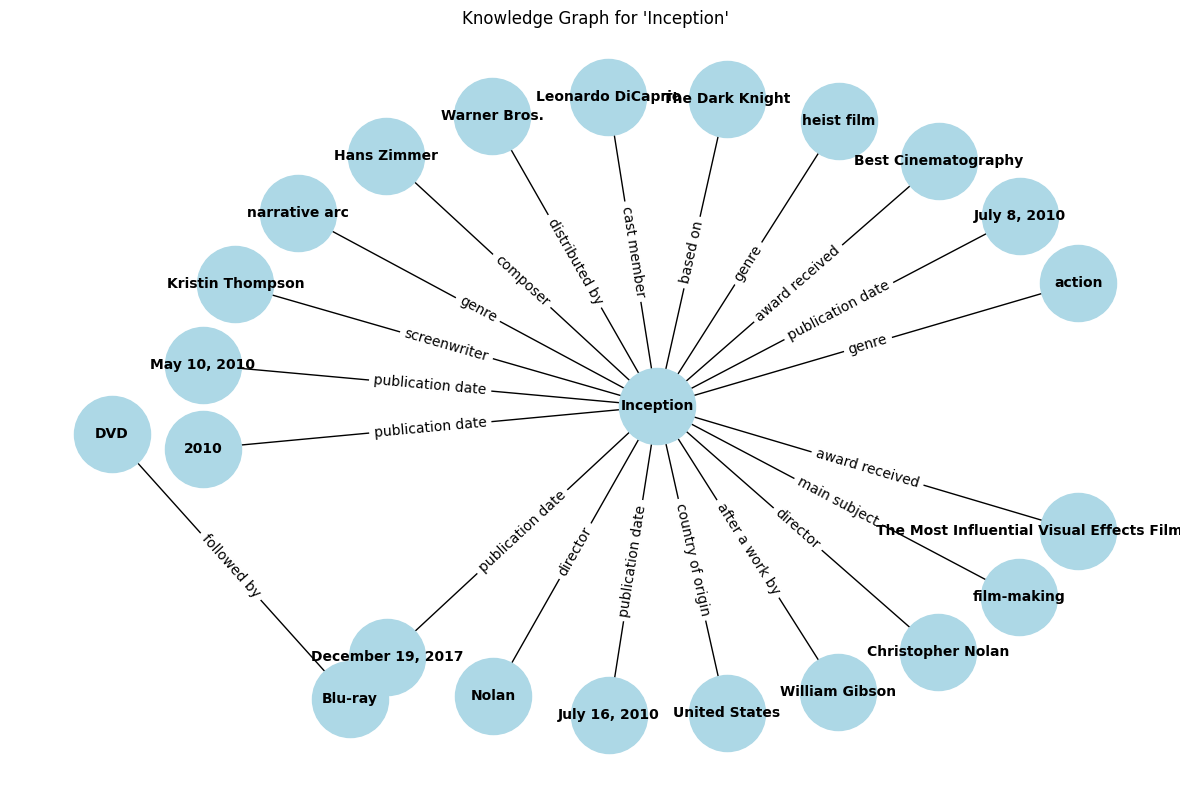


Traitement du film : The Matrix
Raw extraction output:  The Matrix  Matrix film series  part of the series  Keanu Reeves  cast member  Laurence Fishburne  cast member  Carrie-Anne Moss  cast member  Hugo Weaving  cast member  Joe Pantoliano  cast member  Matrix film series  The Matrix  has part  Keanu Reeves  cast member  Laurence Fishburne  cast member  Carrie-Anne Moss  cast member  Hugo Weaving  cast member  Joe Pantoliano  cast member 
Raw extraction output:  Bound  Warner Bros.  distributed by
Raw extraction output:  The Matrix  March 31, 1999  publication date
Raw extraction output:  Best Visual Effects  Academy Awards  instance of  Best Film Editing  Academy Awards  instance of  Best Sound  Academy Awards  instance of  Best Sound Editing  Academy Awards  instance of
Raw extraction output:  Best Sound  Saturn Awards  instance of  Best Special Visual Effects  Saturn Awards  instance of  Best Director  Saturn Awards  instance of  Best Science Fiction Film  Saturn Awards  instance 

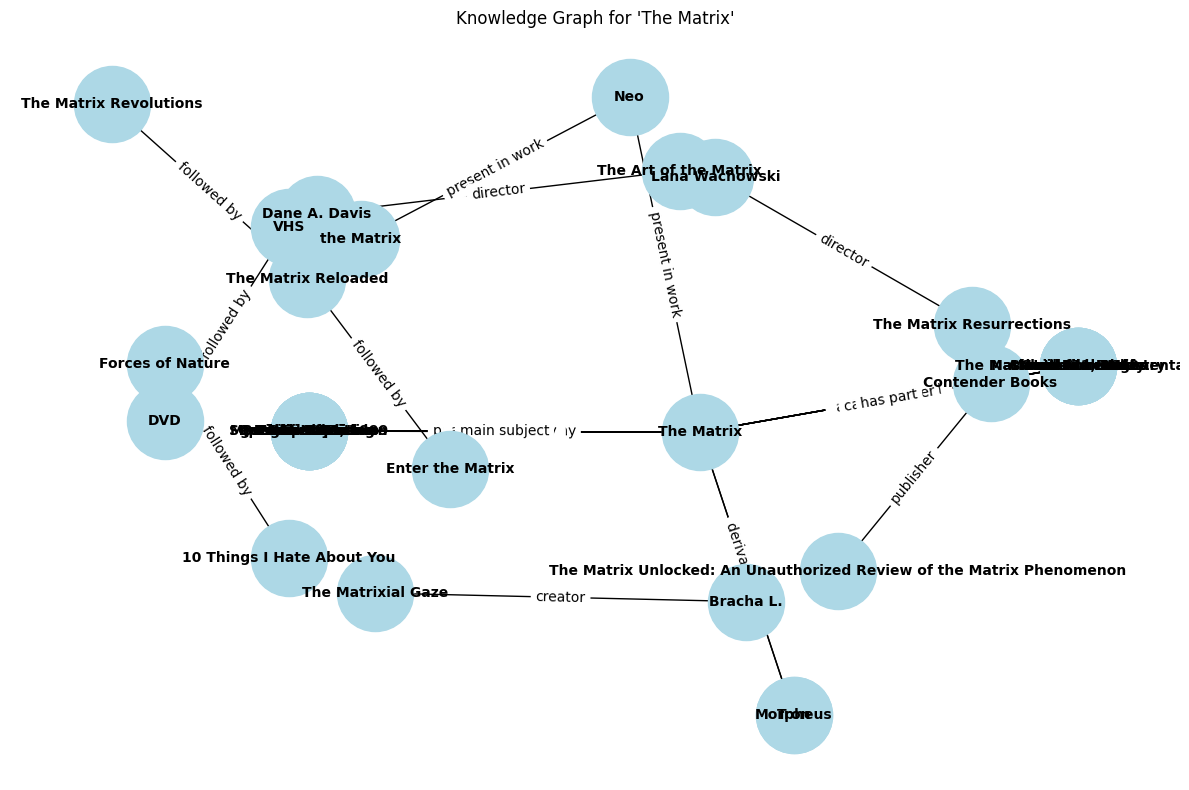

In [37]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import networkx as nx
import matplotlib.pyplot as plt
import requests

# Charger le modèle REBEL
model_name = "Babelscape/rebel-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


# Fonction pour récupérer le résumé Wikipédia
def get_wikipedia_summary(title, language="en"):
    url = f"https://{language}.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
        "redirects": 1  # Suivre les redirections
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        page = next(iter(data["query"]["pages"].values()))
        if "extract" in page:
            return page["extract"]
        else:
            print(f"Aucun résumé trouvé pour le titre '{title}'.")
            return None
    else:
        print(f"Erreur lors de la requête : {response.status_code}")
        return None


# Fonction pour découper le texte en blocs
def split_text(text, max_length=512):
    sentences = text.split(". ")
    blocks = []
    current_block = ""
    for sentence in sentences:
        if len(current_block) + len(sentence) <= max_length:
            current_block += sentence + ". "
        else:
            blocks.append(current_block.strip())
            current_block = sentence + ". "
    if current_block:
        blocks.append(current_block.strip())
    return blocks


# Extraction des entités et relations avec REBEL
def extract_entities_and_relations(block):
    inputs = tokenizer(block, return_tensors="pt", truncation=True, max_length=512)
    outputs = model.generate(**inputs)
    decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    print(f"Raw extraction output: {decoded_output[0]}")
    return decoded_output[0]


# Parser les triples extraits par REBEL
def parse_rebel_output(output):
    triples = []
    statements = output.split('\n')
    for statement in statements:
        parts = statement.split('  ')
        if len(parts) >= 3:
            subject = parts[0].strip()
            obj = parts[1].strip()
            relation = parts[2].strip()
            if subject and obj and relation:
                triples.append((subject, relation, obj))
    return triples


# Filtrer les triples pertinents
def filter_triples(triples, title, relevant_relations=None):
    if relevant_relations is None:
        relevant_relations = ["followed by", "follows"]
    filtered = []
    for triple in triples:
        subject, relation, obj = triple
        if title.lower() in subject.lower() or title.lower() in obj.lower() or relation.lower() in relevant_relations:
            filtered.append(triple)
    return filtered


# Créer un graphe NetworkX à partir des triples
def create_graph(triples):
    graph = nx.DiGraph()
    for triple in triples:
        print(f"Triple: {triple}")
        if len(triple) == 3 and all(triple):
            subject, relation, obj = triple
            graph.add_node(subject)
            graph.add_node(obj)
            graph.add_edge(subject, obj, label=relation)
    return graph


# Visualiser le graphe
def plot_graph(graph, title):
    plt.figure(figsize=(12, 8))
    if len(graph) == 0:
        print(f"Warning: Graph for '{title}' is empty!")
        return
    pos = nx.kamada_kawai_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_color="lightblue", node_size=3000)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_weight="bold")
    nx.draw_networkx_edges(graph, pos)
    edge_labels = nx.get_edge_attributes(graph, 'label')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.title(f"Knowledge Graph for '{title}'")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Pipeline principal pour une liste de films
film_titles = [
    "Ralph Breaks the Internet",
    "Frozen",
    "Inception",
    "The Matrix"
]

for title in film_titles:
    print(f"\nTraitement du film : {title}")
    text = get_wikipedia_summary(title, language="en")
    
    if text:
        text_blocks = split_text(text)
        triples = []

        for block in text_blocks:
            result = extract_entities_and_relations(block)
            block_triples = parse_rebel_output(result)
            triples.extend(block_triples)

        # Filtrer les triples pour garder uniquement ceux pertinents
        filtered_triples = filter_triples(triples, title, relevant_relations=["followed by", "follows"])

        print(f"\nFiltered Triples for '{title}':")
        for triple in filtered_triples:
            print(triple)

        # Créer et afficher le graphe
        knowledge_graph = create_graph(filtered_triples)
        plot_graph(knowledge_graph, title)
    else:
        print(f"Pas de données trouvées pour '{title}'.")
